<a href="https://colab.research.google.com/github/vivekbiju/XAI/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python
!pip install kagglehub
!pip install tensorflow
!pip install shap
!pip install tqdm

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import numpy as np
import os
import cv2
import random
import time
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import kagglehub
import shap
from tqdm import tqdm

In [ ]:
# Set consistent random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Define image dimensions as constants
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Helper function for consistent image loading and preprocessing
def load_and_preprocess_single_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    """
    Loads, resizes, converts to RGB, and preprocesses a single image for model input.
    Args:
        img_path (str): Path to the image file.
        target_size (tuple): Desired (height, width) for resizing.
    Returns:
        tuple: (preprocessed_image_array (batch of 1), original_rgb_resized_image, original_full_size_image)
               Returns (None, None, None) if image cannot be loaded.
    """
    img_full_size = cv2.imread(img_path)
    if img_full_size is None:
        return None, None, None

    img_resized = cv2.resize(img_full_size, target_size)
    img_rgb_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    # Use VGG16's specific preprocess_input
    img_array_preprocessed = preprocess_input(np.expand_dims(img_rgb_resized, axis=0)) # Model input expects batch dim
    return img_array_preprocessed, img_rgb_resized, cv2.cvtColor(img_full_size, cv2.COLOR_BGR2RGB) # Return original RGB for display

Attempting to download dataset...


100%|██████████| 79.4M/79.4M [00:02<00:00, 33.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bhaveshmittal/melanoma-cancer-dataset/versions/1
Number of images benign: 7289
Number of images malignant: 6590


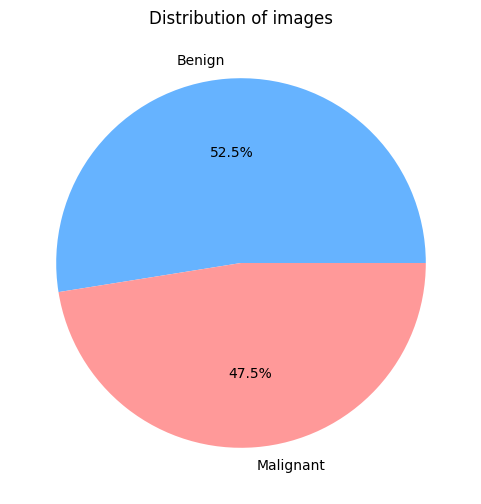

In [ ]:
# Dataset Download & Paths
print("Attempting to download dataset...")
try:
    path = kagglehub.dataset_download("bhaveshmittal/melanoma-cancer-dataset")
    print("Path to dataset files:", path)
except Exception as e:
    print(f"Error downloading dataset from Kaggle Hub: {e}")
    print("Please ensure kagglehub is installed and configured correctly.")
    exit_script = input("Dataset download failed. Do you want to exit the script? (y/n): ")
    if exit_script.lower() == 'y':
        exit()
    else:
        print("Proceeding without dataset. This will likely cause errors later.")
        path = "."

train_path = os.path.join(path, "train")
test_path = os.path.join(path, "test")

# Checkinng if paths exist after download attempt
if not os.path.exists(train_path) or not os.path.exists(test_path):
    print(f"Error: Training or test path not found. Please ensure the dataset is downloaded correctly to '{path}'.")
    exit()

# Count images
ben = len(os.listdir(os.path.join(train_path, "Benign"))) + len(os.listdir(os.path.join(test_path, "Benign")))
mal = len(os.listdir(os.path.join(train_path, "Malignant"))) + len(os.listdir(os.path.join(test_path, "Malignant")))

print(f"Number of images benign: {ben}")
print(f"Number of images malignant: {mal}")

# Pie chart for class distribution
plt.figure(figsize=(6,6))
plt.pie([ben, mal], labels=['Benign', 'Malignant'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
plt.title("Distribution of images")
plt.show()


 sample Benign images


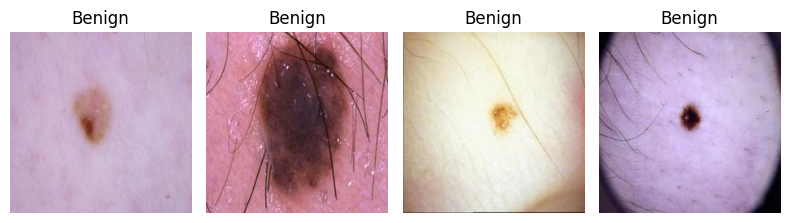


 sample Malignant images


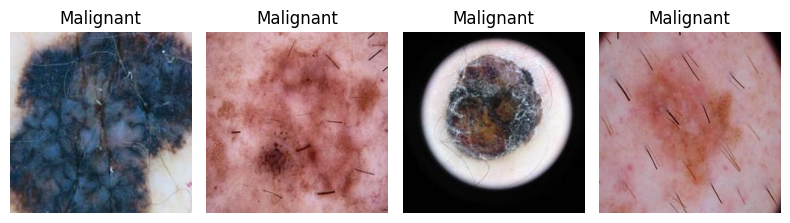

In [ ]:
# Visualize sample images
print("\n sample Benign images")
plt.figure(figsize=(8, 5))
benign_sample_images = [f for f in os.listdir(os.path.join(train_path, 'Benign')) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
for i, img_name in enumerate(benign_sample_images[:4]):
    img_path = os.path.join(train_path, 'Benign', img_name)
    _, img_rgb_display, _ = load_and_preprocess_single_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    if img_rgb_display is not None:
        plt.subplot(2, 4, i + 1)
        plt.imshow(img_rgb_display)
        plt.title("Benign")
        plt.axis('off')
plt.tight_layout()
plt.show()

print("\n sample Malignant images")
plt.figure(figsize=(8, 5))
malignant_sample_images = [f for f in os.listdir(os.path.join(train_path, 'Malignant')) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
for i, img_name in enumerate(malignant_sample_images[:4]):
    img_path = os.path.join(train_path, 'Malignant', img_name)
    _, img_rgb_display, _ = load_and_preprocess_single_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    if img_rgb_display is not None:
        plt.subplot(2, 4, i + 1)
        plt.imshow(img_rgb_display)
        plt.title("Malignant")
        plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Data Generators
print("\nSetting up data generators...")
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # VGG16's preprocess_input
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.1,
    horizontal_flip=True,
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # VGG16's preprocess_input
    validation_split=0.2
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16's preprocess_input

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    shuffle=True,
    subset="training",
    class_mode='categorical',
    batch_size=32,
    seed=42
)

valid_generator = valid_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    subset="validation",
    class_mode='categorical',
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False,
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    seed=42
)


Setting up data generators...
Found 9504 images belonging to 2 classes.
Found 2375 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
# Build model with VGG16 base
print("\nBuilding VGG16-base model...")
vgg = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
vgg.trainable = False

model = tf.keras.Sequential([
    vgg,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax', kernel_regularizer=l2(0.01))
])

model.summary()

# Optimizer and Callbacks
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

callbacks = [reduce_lr, early_stopping]


Building VGG16-base model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,722,930 (56.16 MB)

 Trainable params: 8,242 (32.20 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Train the model
print("\nStarting initial model training (feature extraction)...")
start_time = time.time()
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=callbacks
)
end_time = time.time()
total_time = end_time - start_time
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"\nTotal initial training time: {int(hours)}h {int(minutes)}m {int(seconds)}s")

# Fine-tuning
print("\nStarting fine-tuning of the model...")
vgg.trainable = True

for layer in vgg.layers[:15]:
    layer.trainable = False

optimizer_finetune = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer_finetune, loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=callbacks
)

# Save the trained model
model_save_path = "vgg16_melanoma_detection_model.h5"
try:
    model.save(model_save_path)
    print(f"\nModel saved successfully at: {model_save_path}")
except Exception as e:
    print(f"Error saving model: {e}")



Starting initial model training (feature extraction)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 126s 376ms/step - accuracy: 0.6274 - loss: 1.0816 - val_accuracy: 0.7192 - val_loss: 0.8608 - learning_rate: 1.0000e-04
Epoch 2/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 106s 355ms/step - accuracy: 0.7332 - loss: 0.8136 - val_accuracy: 0.7549 - val_loss: 0.7871 - learning_rate: 1.0000e-04
Epoch 3/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 106s 356ms/step - accuracy: 0.7724 - loss: 0.7201 - val_accuracy: 0.7781 - val_loss: 0.7261 - learning_rate: 1.0000e-04
Epoch 4/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 108s 364ms/step - accuracy: 0.8000 - loss: 0.6383 - val_accuracy: 0.7747 - val_loss: 0.7061 - learning_rate: 1.0000e-04
Epoch 5/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 111s 372ms/step - accuracy: 0.8144 - loss: 0.5945 - val_accuracy: 0.7823 - val_loss: 0.6699 - learning_rate: 1.0000e-04
Epoch 6/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 109s 368ms/step - accuracy: 0.8384 - loss: 0.5589 - val_accuracy: 0.7815 - val_loss: 0.6443 - learning_rate: 1.0000e-04
Epoch 7/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 


Model saved successfully at: vgg16_melanoma_detection_model.h5


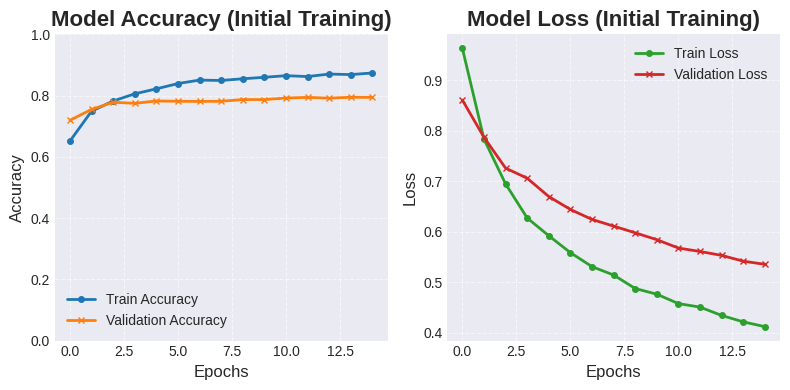

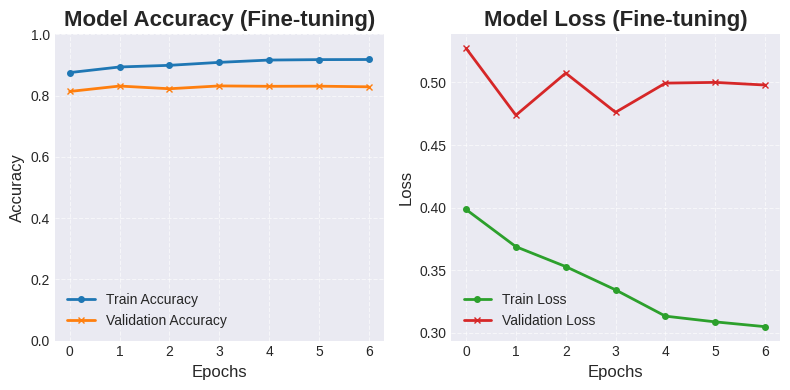


Evaluating model on the test set...
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.9227 - loss: 0.2849
Test Accuracy: 89.75%
Test Loss: 0.3645
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step


In [ ]:
# Plot training & validation accuracy and loss
def plot_training(history_obj, title_suffix=""):
    """
    Plots training and validation accuracy and loss in a professional manner.

    Args:
        history_obj: Keras History object containing training logs.
        title_suffix (str): Suffix to add to the plot titles (e.g., "(Initial Training)").
    """
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.figure(figsize=(8, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_obj.history['accuracy'], label='Train Accuracy', color='#1f77b4', marker='o', markersize=4, linewidth=2)
    plt.plot(history_obj.history['val_accuracy'], label='Validation Accuracy', color='#ff7f0e', marker='x', markersize=4, linewidth=2)
    plt.title(f"Model Accuracy {title_suffix}", fontsize=16, fontweight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylim([0, 1])

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_obj.history['loss'], label='Train Loss', color='#2ca02c', marker='o', markersize=4, linewidth=2)
    plt.plot(history_obj.history['val_loss'], label='Validation Loss', color='#d62728', marker='x', markersize=4, linewidth=2)
    plt.title(f"Model Loss {title_suffix}", fontsize=16, fontweight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()
    plt.style.use('default')

plot_training(history, "(Initial Training)")
plot_training(history_finetune, "(Fine-tuning)")

print("\nEvaluating model on the test set...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

test_generator.reset()
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

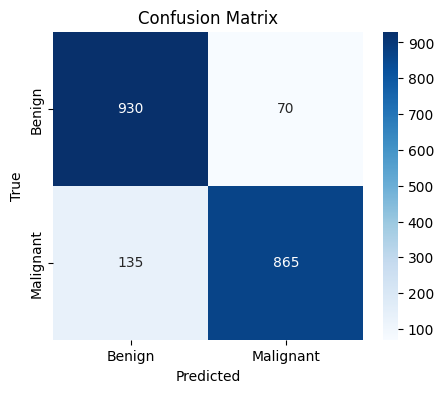

Classification Report:

              precision    recall  f1-score   support

      Benign       0.87      0.93      0.90      1000
   Malignant       0.93      0.86      0.89      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

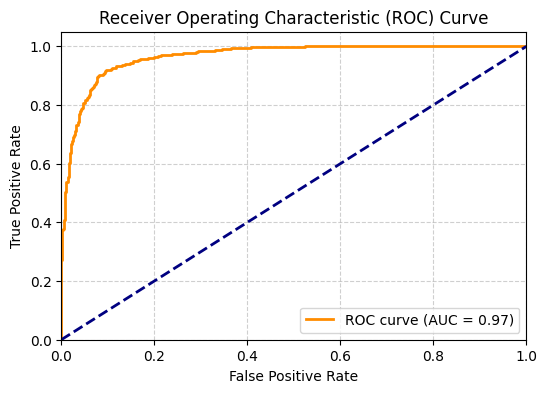

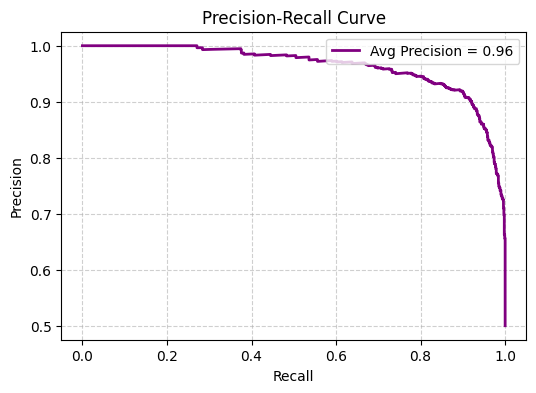

In [ ]:
# ROC Curve
if y_pred_probs.shape[1] == 2:
    y_true_categorical = to_categorical(y_true, num_classes=2)
    fpr, tpr, thresholds = roc_curve(y_true_categorical[:,1], y_pred_probs[:,1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_true_categorical[:,1], y_pred_probs[:,1])
average_precision = average_precision_score(y_true_categorical[:,1], y_pred_probs[:,1])

plt.figure(figsize=(6,4))
plt.plot(recall, precision, color='purple', lw=2, label=f'Avg Precision = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


Visualizing sample predictions from the test set...
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step


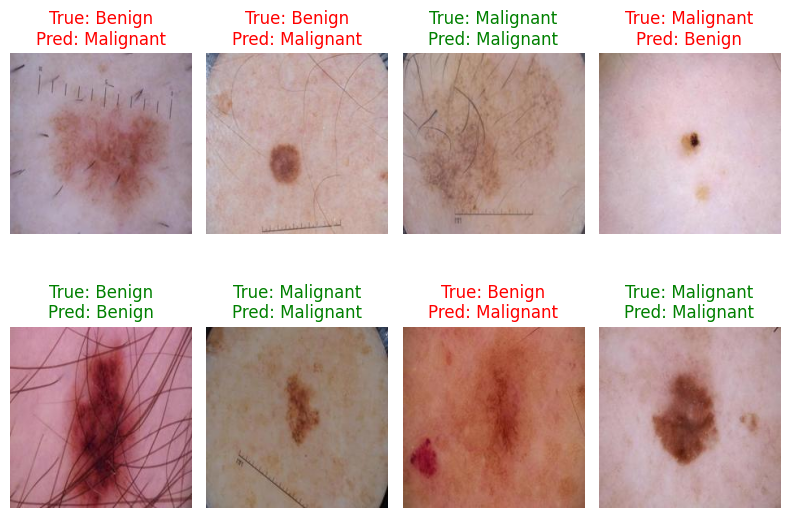

In [ ]:
# Prediction and Visualisation
def visualise_predictions(model, generator, class_names, num_images=8):
    """
    Visualises predictions for a few images from a generator, prioritizing misclassified.
    Args:
        model: Trained Keras model.
        generator: Keras ImageDataGenerator.
        class_names (list): List of class names.
        num_images (int): Number of images to visualise.
    """
    generator.reset()
    true_labels_arr = generator.classes
    pred_labels_arr = np.argmax(model.predict(generator), axis=1)

    correct_indices = np.where(true_labels_arr == pred_labels_arr)[0]
    incorrect_indices = np.where(true_labels_arr != pred_labels_arr)[0]

    selected_indices = []
    # Prioritize misclassified samples
    num_incorrect_to_pick = min(num_images // 2, len(incorrect_indices))
    num_correct_to_pick = min(num_images - num_incorrect_to_pick, len(correct_indices))

    selected_indices.extend(random.sample(list(incorrect_indices), num_incorrect_to_pick))
    selected_indices.extend(random.sample(list(correct_indices), num_correct_to_pick))
    random.shuffle(selected_indices)

    if not selected_indices:
        print("No images to visualize (dataset might be empty or no predictions made).")
        return

    plt.figure(figsize=(8, 3 * (num_images // 4 + (1 if num_images % 4 != 0 else 0))))
    for i, idx in enumerate(selected_indices[:num_images]):
        img_path = generator.filepaths[idx]
        _, img_rgb_display, _ = load_and_preprocess_single_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

        if img_rgb_display is None:
            print(f"Could not load image {img_path}. Skipping.")
            continue

        # Normalize for display [0,1]
        img_display_norm = img_rgb_display.astype(np.float32) / 255.0

        true_label = class_names[true_labels_arr[idx]]
        predicted_label = class_names[pred_labels_arr[idx]]

        plt.subplot(num_images // 4 + (1 if num_images % 4 != 0 else 0), 4, i + 1)
        plt.imshow(img_display_norm)
        color = "green" if true_label == predicted_label else "red"
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Get class names from test generator
class_names = list(test_generator.class_indices.keys())

# Visualise predictions
print("\nVisualizing sample predictions from the test set...")
visualise_predictions(model, test_generator, class_names, num_images=8)


--- Starting Grad-CAM Explanations ---

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step
Attempting to visualize 10 images with Grad-CAM (prioritizing misclassified).


Generating Grad-CAMs:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


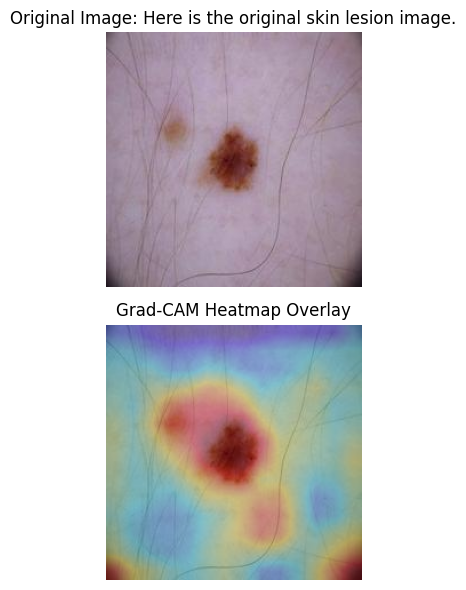

Generating Grad-CAMs:  10%|█         | 1/10 [00:00<00:03,  2.55it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 61.69%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


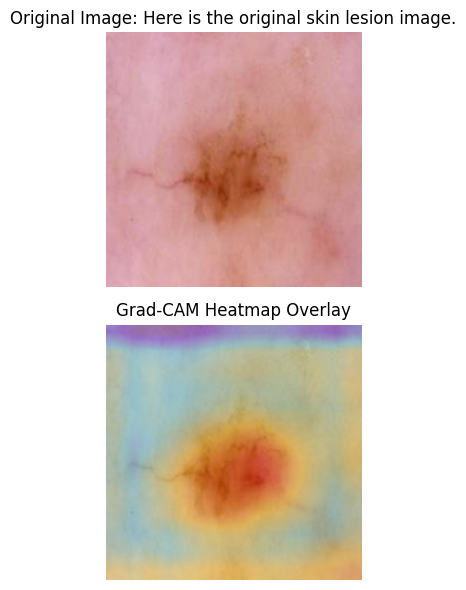

Generating Grad-CAMs:  20%|██        | 2/10 [00:00<00:03,  2.57it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 59.71%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


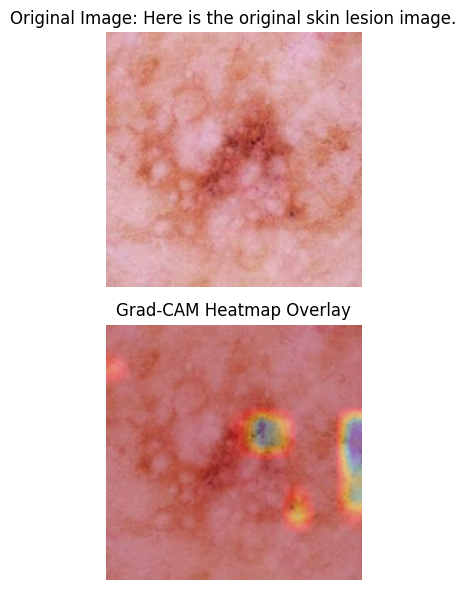

Generating Grad-CAMs:  30%|███       | 3/10 [00:01<00:02,  2.53it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Malignant with a confidence of 50.55%. The red regions represent areas that the model believes to be most indicative of malignant tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


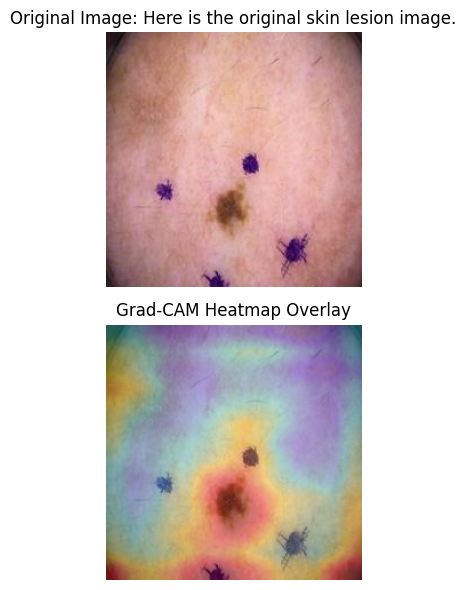

Generating Grad-CAMs:  40%|████      | 4/10 [00:01<00:02,  2.49it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 61.39%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


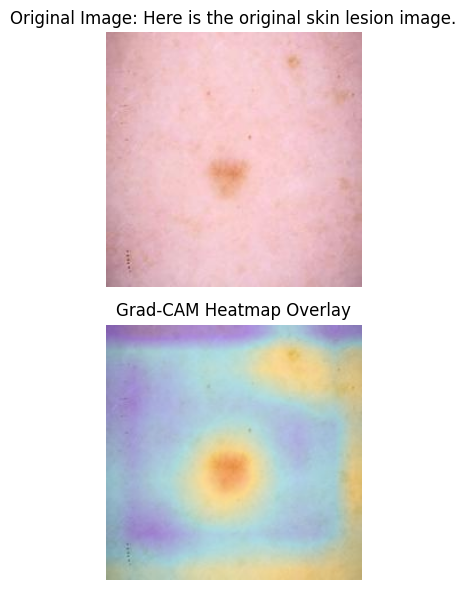

Generating Grad-CAMs:  50%|█████     | 5/10 [00:01<00:01,  2.51it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 60.63%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


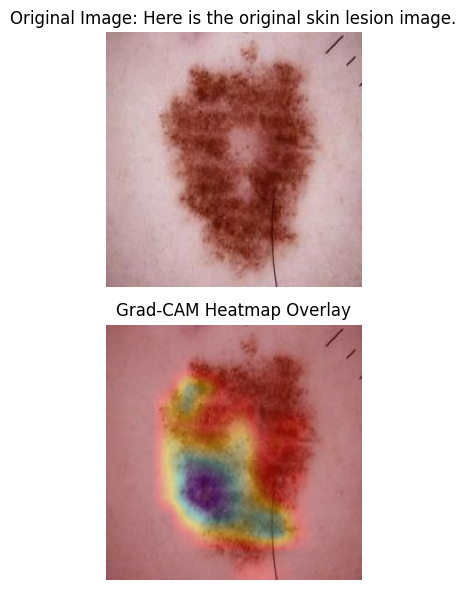

Generating Grad-CAMs:  60%|██████    | 6/10 [00:02<00:01,  2.50it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Malignant with a confidence of 50.66%. The red regions represent areas that the model believes to be most indicative of malignant tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


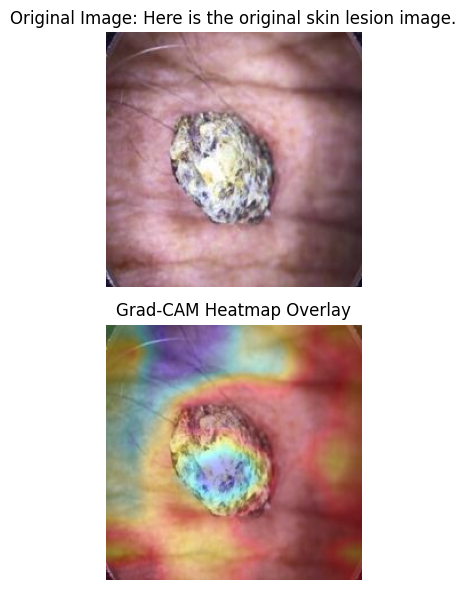

Generating Grad-CAMs:  70%|███████   | 7/10 [00:02<00:01,  2.49it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 50.16%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


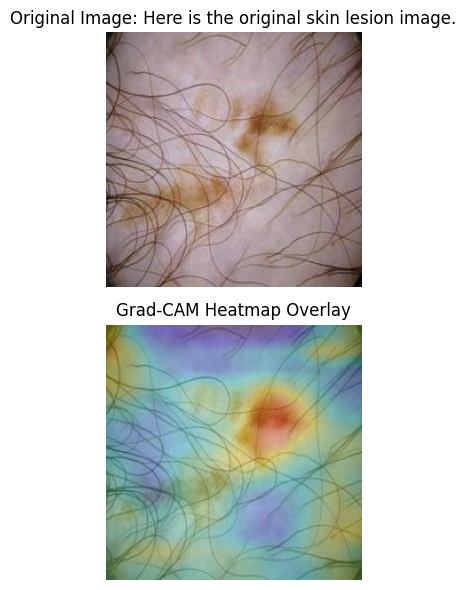

Generating Grad-CAMs:  80%|████████  | 8/10 [00:03<00:00,  2.47it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 63.86%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


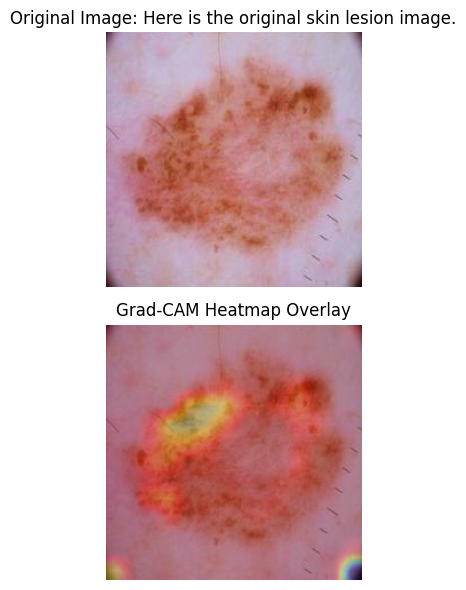

Generating Grad-CAMs:  90%|█████████ | 9/10 [00:03<00:00,  2.45it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Malignant with a confidence of 50.10%. The red regions represent areas that the model believes to be most indicative of malignant tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


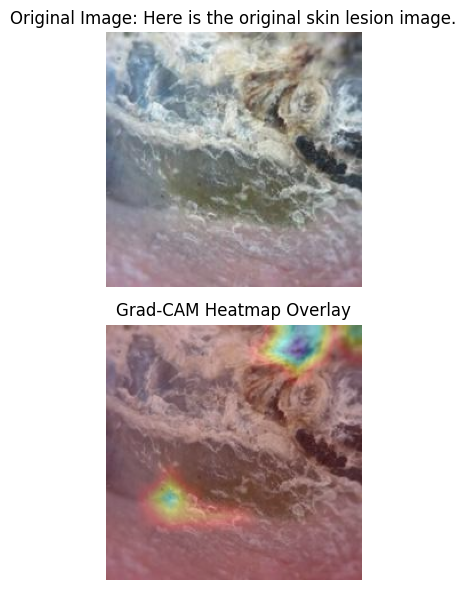

Generating Grad-CAMs: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Malignant with a confidence of 51.55%. The red regions represent areas that the model believes to be most indicative of malignant tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."

 Grad-CAM explanations generated and displayed successfully.


In [ ]:
# Grad-CAM Implementation
print("\n" + "="*50)
print("--- Starting Grad-CAM Explanations ---")
print("="*50 + "\n")

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generates Grad-CAM heatmap for a given image and model.
    Args:
        img_array: Preprocessed image array (batch of 1: (1, H, W, C)).
        model: Trained Keras model.
        last_conv_layer_name: Name of the last convolutional layer in the base model.
        pred_index: Optional. If specified, computes heatmap for this class.
                    Otherwise, computes for the top predicted class.
    Returns:
        Numpy array representing the heatmap or None if gradient is None.
    """
    input_layer = model.layers[0].input
    # Get the VGG16 base model layer
    vgg_base_model = model.get_layer('vgg16')
    last_conv_layer_output = vgg_base_model.get_layer(last_conv_layer_name).output

    x = last_conv_layer_output
    for layer in model.layers[1:]:
        x = layer(x)
    final_output = x

    grad_model = tf.keras.models.Model(
        inputs=input_layer,
        outputs=[last_conv_layer_output, final_output]
    )

    img_array = tf.cast(img_array, tf.float32)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)

        if pred_index is None:
            pred_index = tf.argmax(predictions[0])

        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    if grads is None:
        print("Gradient is None. Returning None for heatmap.")
        return None

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())

    heatmap = tf.cast(heatmap, tf.float32)
    return heatmap.numpy()

# Grad-CAM Visualization Loop
idx_to_class = {v: k for k, v in test_generator.class_indices.items()}

# Get all true labels and predicted labels from the test set
test_true_labels = test_generator.classes
test_pred_labels = np.argmax(model.predict(test_generator), axis=1)

# Separate indices for correct and incorrect predictions
correctly_classified_indices = np.where(test_true_labels == test_pred_labels)[0]
misclassified_indices = np.where(test_true_labels != test_pred_labels)[0]

num_samples_to_visualize_gradcam = 10 #
sample_indices_gradcam = []

# Prioritize misclassified samples for Grad-CAM
num_misclassified_to_pick = min(num_samples_to_visualize_gradcam // 2, len(misclassified_indices))
num_correct_to_pick = min(num_samples_to_visualize_gradcam - num_misclassified_to_pick, len(correctly_classified_indices))

sample_indices_gradcam.extend(random.sample(list(misclassified_indices), num_misclassified_to_pick))
sample_indices_gradcam.extend(random.sample(list(correctly_classified_indices), num_correct_to_pick))
random.shuffle(sample_indices_gradcam)

print(f"Attempting to visualize {len(sample_indices_gradcam)} images with Grad-CAM (prioritizing misclassified).")

# last convolutional layer
last_conv_layer_name = 'block5_conv3'

for i in tqdm(sample_indices_gradcam, desc="Generating Grad-CAMs"):
    img_path = test_generator.filepaths[i]
    img_array_preprocessed, img_rgb_resized, img_rgb_original_full_size = load_and_preprocess_single_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

    if img_array_preprocessed is None:
        print(f"Could not read image at {img_path}. Skipping for Grad-CAM.")
        continue

    original_height, original_width = img_rgb_original_full_size.shape[:2]

    # Get model's predicted class and confidence for the image
    predicted_probs = model.predict(img_array_preprocessed)
    predicted_class_idx = np.argmax(predicted_probs[0])
    predicted_class_label = idx_to_class[predicted_class_idx]
    confidence = predicted_probs[0][predicted_class_idx] * 100

    # Generate heatmap for the predicted class
    heatmap = make_gradcam_heatmap(img_array_preprocessed, model, last_conv_layer_name, pred_index=predicted_class_idx)

    if heatmap is not None:
        heatmap_resized = cv2.resize(heatmap, (original_width, original_height))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

        # Superimpose the heatmap on the original image
        superimposed_img = cv2.addWeighted(img_rgb_original_full_size, 0.7, heatmap_colored, 0.3, 0)

        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        plt.imshow(img_rgb_original_full_size)
        plt.title("Original Image: Here is the original skin lesion image.")
        plt.axis('off')

        plt.subplot(2, 1, 2)
        plt.imshow(superimposed_img)
        plt.title("Grad-CAM Heatmap Overlay")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f'Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."')
        print(f'Explanation: "The model predicts this lesion as {predicted_class_label} with a confidence of {confidence:.2f}%. '
              f'The red regions represent areas that the model believes to be most indicative of {predicted_class_label.lower()} tissue. '
              f'These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."')
        plt.pause(0.1)
    else:
        print(f"Could not generate Grad-CAM for image at index {i}.")

print("\n Grad-CAM explanations generated and displayed successfully.")




--- Starting SHAP Explanations with Partition Explainer ---


 Initiating SHAP explanation display with Partition Explainer 

--- Starting SHAP Explanation with Partition Explainer for 5 images ---
Selected 5 test images for SHAP (2 Benign, 3 Malignant).


Preparing test images for SHAP: 100%|██████████| 5/5 [00:00<00:00, 2279.76it/s]

Preprocessed test images shape for SHAP: (5, 224, 224, 3)
Initializing SHAP Partition Explainer...


Calculating SHAP values for 5 test images... (this may take a while)


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 3/5 [01:05<00:33, 16.74s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 4/5 [01:41<00:24, 24.59s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [02:16<00:00, 28.67s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [02:55, 35.14s/it]

Generating SHAP plots (manual)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



Displaying SHAP plots:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-3511858300.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 1])


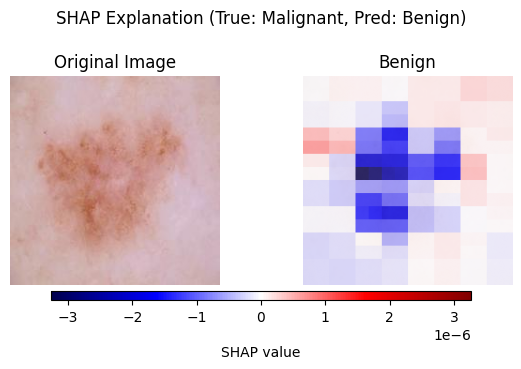

Displaying SHAP plots:  20%|██        | 1/5 [00:00<00:00,  5.06it/s]

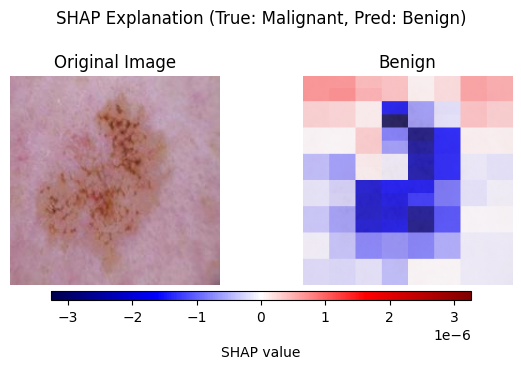

Displaying SHAP plots:  40%|████      | 2/5 [00:00<00:00,  5.09it/s]

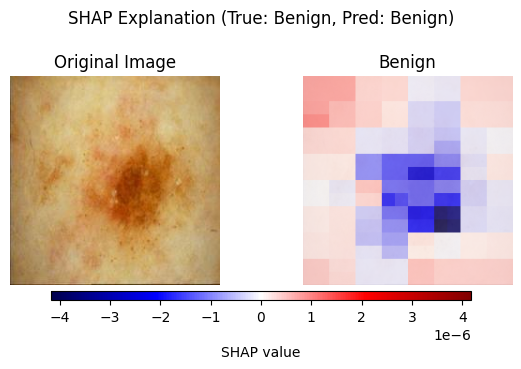

Displaying SHAP plots:  60%|██████    | 3/5 [00:00<00:00,  5.03it/s]

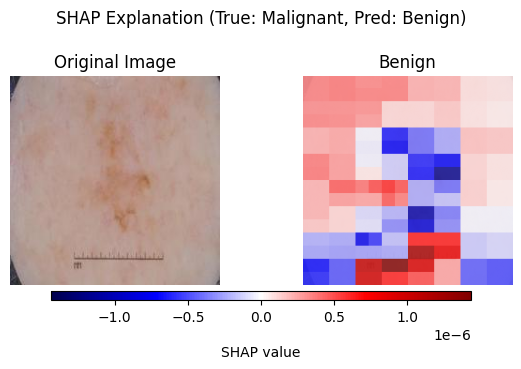

Displaying SHAP plots:  80%|████████  | 4/5 [00:00<00:00,  5.15it/s]

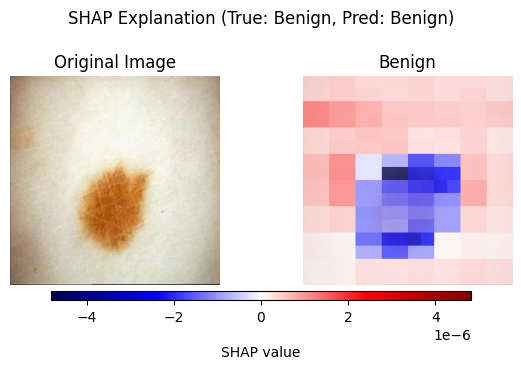

Displaying SHAP plots: 100%|██████████| 5/5 [00:00<00:00,  5.15it/s]

 SHAP explanations generated and displayed successfully.

--- Script finished ---


In [ ]:
# SHAP Explanation Code Integration (Partition Explainer)

print("\n" + "="*50)
print("--- Starting SHAP Explanations with Partition Explainer ---")
print("="*50 + "\n")

def preprocess_input(x):
    # Placeholder for a typical preprocessing function
    return (x / 127.5) - 1.0


def explain_with_partition_explainer(model: tf.keras.Model, test_generator, y_true_test_set: np.ndarray, num_test_total: int = 5, num_classes_to_explain: int = 1):
    """
    Generates and displays SHAP explanations for test images using shap.PartitionExplainer.

    Args:
        model: Trained Keras model.
        test_generator: Data generator containing test images.
        y_true_test_set (np.ndarray): The true labels for the test set.
        num_test_total: Total number of test images to explain.
        num_classes_to_explain: The number of top predicted classes to visualize.
    """
    print(f"\n--- Starting SHAP Explanation with Partition Explainer for {num_test_total} images ---")

    # Select a balanced set of test images for explanation
    test_images_for_shap = []
    original_images_for_display = []
    true_labels_for_shap_indices = []
    selected_test_generator_indices = []

    class_names_map = {v: k for k, v in test_generator.class_indices.items()}
    benign_class_idx = test_generator.class_indices.get('Benign', 0)
    malignant_class_idx = test_generator.class_indices.get('Malignant', 1)

    benign_test_indices = np.where(y_true_test_set == benign_class_idx)[0]
    malignant_test_indices = np.where(y_true_test_set == malignant_class_idx)[0]

    num_benign_to_pick = min(num_test_total // 2, len(benign_test_indices))
    num_malignant_to_pick = min(num_test_total - num_benign_to_pick, len(malignant_test_indices))

    selected_indices = []
    selected_indices.extend(random.sample(list(benign_test_indices), num_benign_to_pick))
    selected_indices.extend(random.sample(list(malignant_test_indices), num_malignant_to_pick))
    random.shuffle(selected_indices)

    if not selected_indices:
        print("Error: No suitable test images (Benign/Malignant) found for SHAP explanation. Exiting.")
        return

    print(f"Selected {len(selected_indices)} test images for SHAP ({num_benign_to_pick} Benign, {num_malignant_to_pick} Malignant).")

    for idx in tqdm(selected_indices, desc="Preparing test images for SHAP"):
        img_path = test_generator.filepaths[idx]
        img = cv2.imread(img_path)
        if img is None:
            print(f"Could not read image at {img_path}. Skipping for SHAP.")
            continue

        img_rgb_resized = cv2.cvtColor(cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)), cv2.COLOR_BGR2RGB)
        original_images_for_display.append(img_rgb_resized)
        test_images_for_shap.append(img_rgb_resized)
        true_labels_for_shap_indices.append(y_true_test_set[idx])
        selected_test_generator_indices.append(idx)

    test_images_for_shap = np.array(test_images_for_shap)
    original_images_for_display = np.array(original_images_for_display)
    true_labels_for_shap_indices = np.array(true_labels_for_shap_indices)

    if test_images_for_shap.shape[0] == 0:
        print("Error: No preprocessed test images collected for SHAP explanation. Exiting.")
        return
    print(f"Preprocessed test images shape for SHAP: {test_images_for_shap.shape}")

    # Defining a model wrapper function for the explainer
    def model_wrapper(x):
        tmp = x.copy()
        tmp = preprocess_input(tmp)
        return model(tmp)

    # Defining a masker and initializing the Partition explainer
    print("Initializing SHAP Partition Explainer...")
    masker = shap.maskers.Image(mask_value="inpaint_telea", shape=test_images_for_shap[0].shape)

    explainer = shap.Explainer(
        model_wrapper,
        masker,
        output_names=list(test_generator.class_indices.keys())
    )

    # Computing the SHAP values for test images
    print(f"Calculating SHAP values for {test_images_for_shap.shape[0]} test images... (this may take a while)")

    # explanations for the top num_classes_to_explain classes
    shap_values = explainer(
        test_images_for_shap,
        max_evals=1000,
        batch_size=50,
        outputs=shap.Explanation.argsort.flip[:num_classes_to_explain]
    )

    # explanations with manual plotting
    print("Generating SHAP plots (manual)")

    predictions_for_shap_images = model.predict(preprocess_input(test_images_for_shap))

    # Get the top predicted classes for each image
    top_predicted_indices = np.argsort(predictions_for_shap_images, axis=1)[:, ::-1][:, :num_classes_to_explain]

    # Looping through the number of images selected for SHAP
    for i in tqdm(range(len(test_images_for_shap)), desc="Displaying SHAP plots"):
        original_img_display = original_images_for_display[i]

        # one column for the original image and num_classes_to_explain columns for the heatmaps
        fig, axes = plt.subplots(1, 1 + num_classes_to_explain, figsize=(3 * (1 + num_classes_to_explain), 3))

        # Overall title
        predicted_classes = [class_names_map.get(idx, "Unknown") for idx in top_predicted_indices[i]]
        true_class_name = class_names_map.get(true_labels_for_shap_indices[i], "Unknown")
        plt.suptitle(
            f"SHAP Explanation (True: {true_class_name}, Pred: {', '.join(predicted_classes)})",
            y=1.02,
            fontsize=12
        )

        # Determine global min/max for color bar across all heatmaps for a single image
        all_heatmap_values = [np.mean(shap_values.values[i, :, :, :, j], axis=-1) for j in range(num_classes_to_explain)]
        global_vmax = np.max([np.max(np.abs(h)) for h in all_heatmap_values])
        global_vmin = -global_vmax

        # Plot 1: Original Image
        axes[0].imshow(original_img_display)
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        # Plot 2 onwards: SHAP heatmaps for each of the top classes
        for j in range(num_classes_to_explain):
            current_shap_values_for_class = shap_values.values[i, :, :, :, j]
            class_name = class_names_map.get(top_predicted_indices[i][j], "Unknown")

            # Take the mean across channels
            heatmap = np.mean(current_shap_values_for_class, axis=-1)

            # Plot the heatmap
            axes[j+1].imshow(original_img_display, alpha=0.5)
            axes[j+1].imshow(heatmap, cmap='seismic', vmin=global_vmin, vmax=global_vmax, alpha=0.8)
            axes[j+1].set_title(class_name)
            axes[j+1].axis('off')

        # single color bar for all heatmaps
        cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])
        norm = Normalize(vmin=global_vmin, vmax=global_vmax)
        sm = ScalarMappable(cmap='seismic', norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('SHAP value', labelpad=15)

        plt.tight_layout(rect=[0, 0.05, 1, 1])
        plt.show()

    print(" SHAP explanations generated and displayed successfully.")


#  Calling the new SHAP explanation function at the end of the script
try:
    print("\n Initiating SHAP explanation display with Partition Explainer ")
    explain_with_partition_explainer(model, test_generator, y_true, num_test_total=5, num_classes_to_explain=1)
except Exception as e:
    print(f"An error occurred during SHAP explanation display: {e}")

print("\n--- Script finished ---")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import nbformat

# Path to the notebook saved in Drive
notebook_path = "/content/drive/MyDrive/Colab Notebooks/VGG16_XAI.ipynb"
cleaned_path = "/content/drive/MyDrive/Colab Notebooks/VGG16_clean.ipynb"

# Load, remove 'widgets' metadata if it exists, and save
nb = nbformat.read(notebook_path, as_version=4)
if "widgets" in nb.get("metadata", {}):
    del nb["metadata"]["widgets"]
nbformat.write(nb, cleaned_path)

print("Cleaned notebook saved to:", cleaned_path)

Cleaned notebook saved to: /content/drive/MyDrive/Colab Notebooks/VGG16_clean.ipynb
